# Как сервисы будут хранить данные?
## Окружение
Для того, чтобы сообразить как удобнее и эффективнее всего хранить данные сервисов RAG-слоя в redis, поднял redis-stack.

```bash
> docker pull redis/redis-stack
> docker run -d --name redis-stack -p 6379:6379 -p 8001:8001 redis/redis-stack:latest
```

Почему redis-stack? Оне предоставляет расширенный набор возможностей. В частности тип данных JSON, а также хранение многомерных векторов с векторным поиском. Лицензия для внутреннего использования бесплатна (если вдруг России снова станет не начхать на лицензии). Есть вебморда для удобного доступа к данным. Да и в целом Redis двигает себя на рынке как эффективное решение для построение real-time приложений на базе AI. В redis-stack есть все фичи.
Подробности тут:
* https://redis.io/about/about-stack/
* https://redis.io/redis-for-ai/

## Поработаем руками и подумаем
### Python зависимости

In [1]:
!pip install redis[hiredis]


  Obtaining dependency information for redis[hiredis] from https://files.pythonhosted.org/packages/e8/02/89e2ed7e85db6c93dfa9e8f691c5087df4e3551ab39081a4d7c6d1f90e05/redis-6.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for hiredis>=3.2.0 from https://files.pythonhosted.org/packages/52/5f/1148e965df1c67b17bdcaef199f54aec3def0955d19660a39c6ee10a6f55/hiredis-3.2.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.1/170.1 kB 1.8 MB/s eta 0:00:0031m1.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 5.5 MB/s eta 0:00:003 MB/s eta 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


### Инициируем клиент

In [13]:
import redis

r = redis.Redis()

### Сгенерируем строковое значение большого размера

In [14]:
import string
import secrets

size = 5 * 1024 * 1024

data = bytearray(size)
view = memoryview(data)
for position in range(size):
    view[position] = ord(secrets.choice(string.printable))

long_5Mb_string = data.decode('utf8')

### String

In [15]:
# Имитация того, что в значении сериализованный JSON размером 25Мб
r.set('long_string', long_5Mb_string * 5)
res = r.get('long_string')
len(res)/1024/1024

25.0

Можно хранить всё в строках. Ключи будут полностью составными, например:
```
chat_id:request_id:files
chat_id:request_id:query
```
Способ медленный и неудобный в использовании. Невозможно удалить все данные запроса или чата одним махом, нужен перебор всех ключей и сравнение с шаблоном из логики образования ключей. **Не годится.**

### Hash

In [16]:
# Составной ключ chat_id::request_id
# В работе будут ключи длинее
key = f'{secrets.token_urlsafe(nbytes=12)}::{secrets.token_urlsafe(nbytes=12)}'
print(key)

dPuDmlaCU8eLci0G::KuGU5HTh_QURDay2


In [17]:
# В query лежит строка на 10Мб (имитация сериализованного в строку JSON)
r.hset(key, mapping={'user': 'username', 'query': long_5Mb_string * 2, 'grade': 12345})

3

In [18]:
result = r.hgetall(key)
print(result.keys())
# Не буду печатать значения, объём большой

dict_keys([b'grade', b'user', b'query'])


In [19]:
r.hget(key, 'grade')

b'12345'

In [20]:
# Другой сервис добавил свой JSON на 15Мб
r.hset(key, 'files', data.decode('utf8') * 3)

1

Удобнее, чем строка. Часть логики по составлению ключей переложили на тип данных, но не всю. Ключи остаются составными, нужен перебор всех ключей для удаления. **Подходит плохо**

### Set

Не подходит совсем

### List, Sorted set

Хуче, чем Hash. В логике сервисов необходимо учитывать порядок значений. Ключ остаётся составным, как в Hash. **Не подходит**

### Vector set

Не подходит для хранения данных сервисов RAG-слоя, тем не менее, эта структура данных заслуживает отдельного внимания и изучения из кода.
Советую почитать вот это:
* https://redis.io/docs/latest/develop/ai/search-and-query/vectors/

Было бы интересно построить какие-нибудь фичи на Redis Vector set. Например для временного хранения векторов документов, залитых пользователем. Или, например, как векторную базу данных для горячих данных. Надо подумать. Ещё надо попросить Алексея рассказать рассматривал ли он Redis как векторную базу данных. Вряд ли он расссматривал этот вариант всерьёз, но, быть может, успел узнать что-то интересное.

### Streams

Структура данных, которая ведёт себя как append-only log. Из стрима можно читать, наподобие `tail -f` любым количеством читателей. Понятное, дело, что в общем случае для данных сервисов RAG-слоя это не подходит. Но зато на Redis Stream можно реализовать интерактивный ответ от LLM.

Вот смотрите, API в ближайшей реализации может отдать ответ из LLM только целиком, так как только после того, как AdapterLLM получит полный ответ от LLM, он кладёт его в БД Контекста и сообщает об успешно выполненной задаче Супервизору (через шину).

```mermaid
flowchart LR


LLM(((LLM))) ---> Allm([Adapter LLM]) 
-- LLM Answer --> DB[( DBContext )]
Allm -. DoneMessage .-> DBus@{ shape: cyl, label: Шина }
-. HasAnswerMessage .-> API
DB -- LLM Answer --> API -- LLM Answer --> User((User))
```

Теперь, с использованием Redis Stream, Adapter'у начинает читать ответ из LLM стримом, при этом сразу сообщает в шину, что ответ есть, а сами данные льёт в Redis Stream. API получает сообщение о том, что появился ответ в виде стрима, начинает читать стрим из Redis и отдавать его пользователю (это вариант, где клиент пользователя ожидает ответа в открытом соединении).

```mermaid
flowchart LR
  
  
  LLM(((LLM))) e1@==> Allm([Adapter LLM])
  Allm e2@== LLM Answer ==> DB[( DBContex / Redis / Stream )]
  DB e3@== LLM Answer ==> API
  API e4@== LLM Answer ==> User((User))
  Allm -. HasStreamMessage .-> DBus@{ shape: cyl, label: Шина }
  DBus@{ shape: cyl, label: Шина } -. HasStreamMessage .-> API
  
  e1@{ animate: true }
  e2@{ animate: true }
  e3@{ animate: true }
  e4@{ animate: true }
  
```

О завершении чтения адаптером ответа данных тоже необходимо сообщать, чтобы АПИ знало, что данные закончились. Сразу оговорюсь, что это упрощённая схема и мимо Супервизора сообщения от сервисов не ходят.

```mermaid
flowchart LR
  
  
  LLM(((LLM))) e1@==> Allm([Adapter LLM])
  Allm e2@== LLM Answer ==> DB[( DBContex / Redis / Stream )]
  DB e3@== LLM Answer ==> API
  API e4@== LLM Answer ==> User((User))
  Allm -. HasStreamMessage .-> DBus@{ shape: cyl, label: Шина }
  Allm -. DoneMessage .-> DBus@{ shape: cyl, label: Шина }
  DBus@{ shape: cyl, label: Шина } -. HasStreamMessage .-> API
  DBus@{ shape: cyl, label: Шина } -. StreamFinishedMessage .-> API
  
  e1@{ animate: true }
  e2@{ animate: true }
  e3@{ animate: true }
  e4@{ animate: true }
  
```
Таким образом мы получаем ответ от LLM, который хранится в БД и его можно прочитать любое количество раз, при этом, пока он пишется, его можно отдавать пользователю в режиме stream. При этом, при обрыве соединения и переподключении, пользователь получит либо весь записанны ответ целиком + стрим с дописыванием, либо дописывание с того места, где он остановился читать, простор для реализации идей.


Всё остальное Event-Driven, для чего задумывался Redis Stream, любую событийно ориентированную логику, в нашем технологическом стеке лучше строить на RabbitMQ, там больше возможностей.

### Geospatial

Удобно для нахождения гео меток в указанном радиусе или в заданном прямоугольнике. Нам без надобности.

### Bitmaps, Bitfields

Не для данных RAG-сервисов конечно, но надо подумать

### JSON

Целевой тип данных, то ради чего затевалось "Поработать руками и подумать". Предполагаю, что можно забыть составные ключи и использовать Redis, как документоориентированную БД со всеми преимуществами запросов по JSON ([Redis Query Engine](https://redis.io/docs/latest/develop/ai/search-and-query/)). Давайте попробуем.

#### Предположительная схема данных одного запроса

In [21]:
import time

chat_id, _, request_id = key.partition('::')

answer_stream_key = secrets.token_urlsafe(nbytes=12)
full_json_data = {
    'request_id': request_id,
    'chat_id': chat_id,
    'created_at': time.time(),
    'query': long_5Mb_string,
    'external_search_files': ['url1', 'url2'],  # Формат содержимого нужно уточнить
    'vector_search_files': [
        # Формат содержимого нужно уточнять. Внизу пример для проверки работы вложенности. Можно взять за основу.
        {
            'file_name': 'abc',
            'content_location': {'chapter': 15, 'paragraph': 10},
            'content': long_5Mb_string[:1024],
        },
        {
            'file_name': 'some rules',
            'content_location': {'chapter': 2, 'paragraph': 8},
            'content': long_5Mb_string[500:1024*2],
        },
    ], 
    'prompt': long_5Mb_string[1000:3000],
    'optimized_prompt': long_5Mb_string[1000:2000],
    'answer_stream_key': answer_stream_key,
}

In [22]:
from copy import deepcopy

# Подготовим документы

# Скопируем данные из примера
data1 = deepcopy(full_json_data)
data2 = deepcopy(full_json_data)
data3 = deepcopy(full_json_data)
data4 = deepcopy(full_json_data)

# Разные запросы одного чата
data1['request_id'] = secrets.token_urlsafe(nbytes=12)
data2['request_id'] = secrets.token_urlsafe(nbytes=12)
data3['request_id'] = secrets.token_urlsafe(nbytes=12)

# Тут запрос из другого чата
data4['request_id'] = secrets.token_urlsafe(nbytes=12)
data4['chat_id'] = str(secrets.token_bytes(nbytes=12))
data4['vector_search_files'][0]['file_name'] = 'qwerty'  # Другой файл

In [23]:
# Cоздаём объект под ключом 'requests' в корневом JSON Redis,
# в котором будут лежать данные запросов пользователей
r.json().set('requests', '$', {})

True

In [24]:
# Запишем полные данные
print(r.json().set(data1['request_id'], '$.requests', data1))
print(r.json().set(data2['request_id'], '$.requests', data2))
print(r.json().set(data3['request_id'], '$.requests', data3))
print(r.json().set(data4['request_id'], '$.requests', data4))

# Данные лежать в корневом JSON'е Redis под общим ключом 'reqeusts', 
# далее под ключом ID записи. Я за ID записи взял request_id,
# это просто пример, ID можно генерировать, на логику это не повлияет.
global_redis_json = {
    'requests': {
        'id1': {}, # data1
        'id2': {}, # data2
        # ...
    }
}

ResponseError: new objects must be created at the root

Посмотрел в доку, судя по всему такая схема не подойдёт, надо новые объекты создавать в корневом. Значит
писать будем в корень, под идентификатором, начинающимся, например со слова `request`, чтобы не путаться.

In [25]:
# Запишем полные данные

def get_root_key(some_data: dict) -> str:
    return f'request:{some_data["request_id"]}'

print(r.json().set(get_root_key(data1), '$', data1))
print(r.json().set(get_root_key(data2), '$', data2))
print(r.json().set(get_root_key(data3), '$', data3))
print(r.json().set(get_root_key(data4), '$', data4))

# Данные лежат в корневом JSON'е Redis под ключами 'request:{ID}' 
# Я за ID записи взял request_id, это просто пример,
# ID можно генерировать, на логику это не повлияет.
global_redis_json = {
    'request:id1': {}, # data1
    'request:id2': {}, # data2
        # ...
}

True
True
True
True


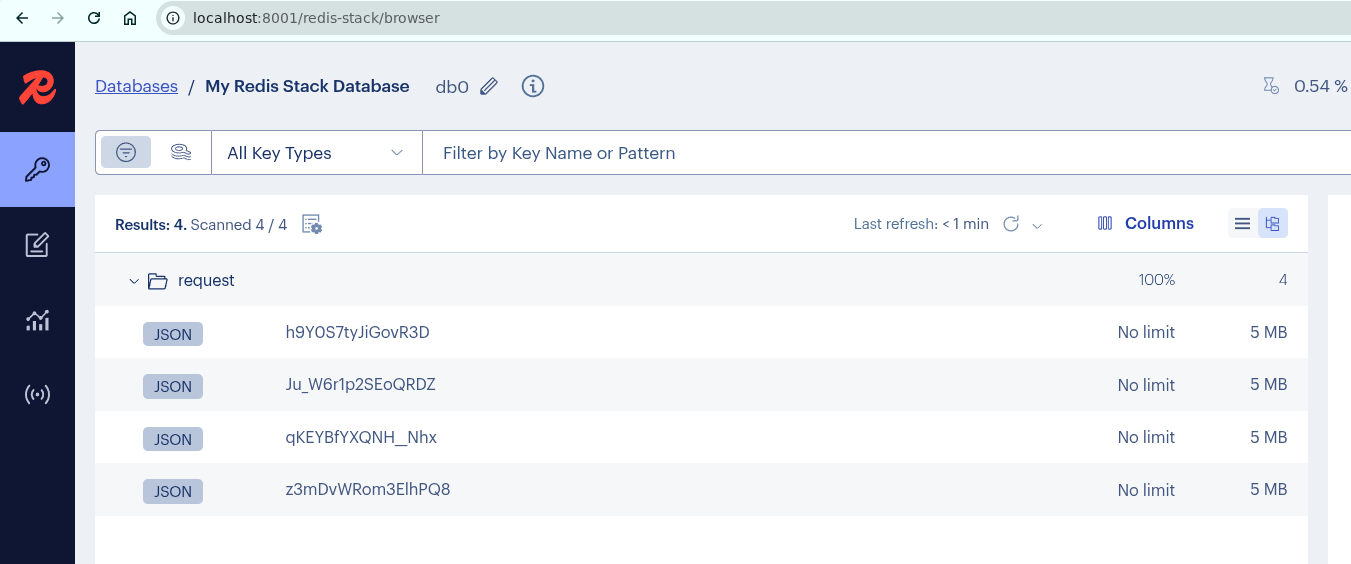

В браузере видно, что ключи, формируемые таким образом Redis группируются. Не зря, сделал как в документации. Верной дорогой идём, товарищи.

Теперь попробуем поделать запросы.

In [26]:
# Все данные по request_id
target_key = get_root_key(data2)

data = r.json().get(target_key)
print('Keys:', data.keys())
print()
print(f'chat_id = {data["chat_id"]}')
print(f'query = {repr(data["query"][:100])}...')  # размер большой, печатаю кусочек

Keys: dict_keys(['request_id', 'chat_id', 'created_at', 'query', 'external_search_files', 'vector_search_files', 'prompt', 'optimized_prompt', 'answer_stream_key'])

chat_id = dPuDmlaCU8eLci0G
query = "!\t^GC8,@O,W7\\vY8GRhCYKW&\x0cr\\^Or[;0sGo~J%0'r( uLi\x0b}7ChQH.$AS%uxn.`CVx;\r\nc`_,{tC=ow`U{o2\\N_-r'bI!Yi c1R"...


In [27]:
# Все запросы чата
print(r.json().get('$', '*'))

None


In [28]:
# Все устаревшие запросы
rotten_at = time.time() - 60 * 60 * 24   # Сутки назад
print(r.json().get('$', f'$..created_at > {rotten_at}'))


None


Нужно время, чтобы разобраться с самими запросами и с тем, как удобнее всего положить данные.
В документации есть хорошие примеры запросов по спискам. Судя по всему надо переложить все объекты запросов в список.
В этом случае структура получится примерно такая:
```python
global_redis_json = {
    'requests': [
        {}, # data1
        {}, # data2
        # ...
    ]
}
```

Я полагаю, что ход моих мыслей ясен, JSON - рабочий вариант, осталось найти рабочие примеры.
Текущую версию документа я отправляю на рассмотрение коллегам, сам продолжу, 

### Попытка номер 3, документы запросов в списке

Почистил Redis, теперь заново положим данные.

In [31]:
# Теперь под requests список
r.json().set('requests', '$', [])

True

In [32]:
# Запишем полные данные

# Эффективность arrappend: O(1)
print(r.json().arrappend('requests', '$', data1))
print(r.json().arrappend('requests', '$', data2))
print(r.json().arrappend('requests', '$', data3))
print(r.json().arrappend('requests', '$', data4))

# Данные лежат в корневом JSON'е Redis под ключами 'request:{ID}' 
# Я за ID записи взял request_id, это просто пример,
# ID можно генерировать, на логику это не повлияет.
global_redis_json = {
    'requests':[
        {}, # data1
        {}, # data2
        # ...
    ]
}

[1]
[2]
[3]
[4]


In [34]:
# Все запросы
all_requests = r.json().get('requests')

print(len(all_requests))
for item in all_requests:
    print(item['request_id'])

4
VIFO3UEJXtjlYfE4
uZ6rXWoBem0dB2ow
v6WF1yX6ROyFwq0K
vxQDEx_Dfz2_PuN3


In [52]:
# Все данные одного запроса по request_id
requests = r.json().get('requests', f'$..[?(@.request_id == \'{data2["request_id"]}\')]')
print(f'Type: {type(requests)}')
print(f'Length: {len(requests)}')
print(f'Type: {type(requests[0])}')
print(f'request_id: {requests[0]["request_id"]}')
print()
print(requests[0].keys())

Type: <class 'list'>
Length: 1
Type: <class 'dict'>
request_id: uZ6rXWoBem0dB2ow

dict_keys(['request_id', 'chat_id', 'created_at', 'query', 'external_search_files', 'vector_search_files', 'prompt', 'optimized_prompt', 'answer_stream_key'])


In [58]:
# Все запросы одного чата
requests = r.json().get('requests', f'$..[?(@.chat_id == \'{data2["chat_id"]}\')]')
print(f'Type: {type(requests)}')
print(f'Length: {len(requests)}')
print()
for num in range(len(requests)):
    print(f'Type: {type(requests[num])}')
    print(f'chat_id: {requests[num]["chat_id"]}, request_id: {requests[num]["request_id"]}')
print()
print(requests[0].keys())


Type: <class 'list'>
Length: 3

Type: <class 'dict'>
chat_id: dPuDmlaCU8eLci0G, request_id: VIFO3UEJXtjlYfE4
Type: <class 'dict'>
chat_id: dPuDmlaCU8eLci0G, request_id: uZ6rXWoBem0dB2ow
Type: <class 'dict'>
chat_id: dPuDmlaCU8eLci0G, request_id: v6WF1yX6ROyFwq0K

dict_keys(['request_id', 'chat_id', 'created_at', 'query', 'external_search_files', 'vector_search_files', 'prompt', 'optimized_prompt', 'answer_stream_key'])


In [72]:
# Неполные данные (Отдельные ключи)
# Попробуем выбрать все файлы всех запросов одного чата
data_query = f'$..[?(@.chat_id == \'{data2["chat_id"]}\')].vector_search_files'
print(f'{data_query=}')
print()
requests = r.json().get('requests', data_query)
print(f'Type: {type(requests)}')
print(f'Length: {len(requests)}')
print()

from pprint import pprint

pprint(requests[0])


data_query="$..[?(@.chat_id == 'dPuDmlaCU8eLci0G')].vector_search_files"

Type: <class 'list'>
Length: 3

[{'content': '!\t^GC8,@O,W7\\vY8GRhCYKW&\x0c'
             "r\\^Or[;0sGo~J%0'r( uLi\x0b"
             '}7ChQH.$AS%uxn.`CVx;\r\n'
             "c`_,{tC=ow`U{o2\\N_-r'bI!Yi c1Ry?q8b\x0c"
             ' PJ%HD*o@_fYf{@19*xZ(};kdw{TMa968<2WKumFoKa;RM\x0c'
             '!+9=4@L/WG0X/6P%dol$5yl*z#dIGcI/<j[I4#+Nwtt(9f_i4rnX\\\x0c'
             't?7zz!=Krd!exI;\n'
             ' ;vdi+O w7&X@[3NIKS {U25K6XVjmeUVz\r'
             '-30Y`g%e\\^.Kd63:7^4.#K;Sx:h!1S:495A^FCyP\x0c'
             'R?um,W@#|BL|@D5GTULTeLP!\r'
             'HCj\n'
             '|>\x0b'
             '-_.6OtD\n'
             '7ItK{.}Q:\n'
             '_vVoN3f>nCg-)-BhJVyse*]+iC+@?c"!Pvt+ Y4Vs1lYs+Z=t0+w<IkT&\'P=>|\n'
             'mxl+seFAb6vIk#-T]L/\\S/28dWS-\x0c'
             '!A?K(scbcj^h6;"\r'
             '.Y~&<VYIx1Wi;6j)z9Kn>d@=8ko0IB#}*i\n'
             '4kCG32ov1>\tMP_}\n'
             ");\t6'J(Udux9KjY,)\n"
 

In [82]:
# Устаревшие запросы
# Получим request_id всех устаревших запросов
rotten_at = time.time() - 60 * 60 * 24   # Сутки назад (так должно быть, но это сейчас не отработает, всё свежее)
rotten_at_10seconds = time.time() - 10   # Всё, что старше 10 секунд назад

data_query1 = f'$..[?(@.created_at < {rotten_at})].request_id'
data_query2 = f'$..[?(@.created_at < {rotten_at_10seconds})].request_id'
print(f'{data_query=}')
print()
print(r.json().get('requests', data_query1))  # не успело протухнуть
print(r.json().get('requests', data_query2))  # тут должны быть все документы через 10 секунд

data_query='$..[?(@.created_at < 1758892457.1518474)].request_id'

[]
['VIFO3UEJXtjlYfE4', 'uZ6rXWoBem0dB2ow', 'v6WF1yX6ROyFwq0K', 'vxQDEx_Dfz2_PuN3']


# Найти в документации:

Блокирование JSON при поиске

Время жизни записей 

С точки зрения масштабирования Redis

Сравнение скоростей двух подходво (JSON vs консервативный подход)

Я проверяю блокировку до понедельника. Если блокировки нет, то берём в реализацию. 